# **IMPORTS**

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.losses import MeanSquaredError
from keras.optimizers import Adam
from keras.regularizers import L2
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import RootMeanSquaredError
from keras.layers import *
import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

# **DATA** **LOADING**

In [17]:
df = pd.read_excel("Cluster_Data_HDBSCAN.xlsx", sheet_name="cluster4", skiprows=1, header=None)

In [18]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,52
0,1.038189,1.042940,1.050455,1.051986,1.042848,1.044636,1.028453,1.062921,1.038071,1.053921,...,1.002004,1.003079,1.017664,1.002964,1.006845,1.017111,1.028811,1.000000,1.000701,1.000000
1,1.059892,1.067785,1.081516,1.080560,1.063593,1.069254,1.043453,1.100351,1.059097,1.082574,...,1.005694,1.003572,1.022371,1.003439,1.007942,1.028828,1.036840,1.001543,1.000952,1.002001
2,1.034006,1.040393,1.056593,1.041552,1.020535,1.036086,1.019623,1.064199,1.030923,1.038288,...,1.011734,1.000464,1.009029,1.000447,1.001033,1.033031,1.015923,1.005234,1.000248,1.008252
3,1.023853,1.029157,1.046919,1.029965,1.008532,1.033897,1.011901,1.043872,1.024890,1.015345,...,1.009425,1.017705,1.015442,1.018994,1.018788,1.045669,1.061714,1.044144,1.074928,1.050397
4,1.028510,1.033387,1.048408,1.039257,1.022222,1.043861,1.018127,1.046527,1.032144,1.024264,...,1.008028,1.017162,1.016747,1.017567,1.018752,1.040420,1.060885,1.041849,1.086985,1.053931


,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,52
0,1.038189,1.042940,1.050455,1.051986,1.042848,1.044636,1.028453,1.062921,1.038071,1.053921,...,1.002004,1.003079,1.017664,1.002964,1.006845,1.017111,1.028811,1.000000,1.000701,1.000000
1,1.059892,1.067785,1.081516,1.080560,1.063593,1.069254,1.043453,1.100351,1.059097,1.082574,...,1.005694,1.003572,1.022371,1.003439,1.007942,1.028828,1.036840,1.001543,1.000952,1.002001
2,1.034006,1.040393,1.056593,1.041552,1.020535,1.036086,1.019623,1.064199,1.030923,1.038288,...,1.011734,1.000464,1.009029,1.000447,1.001033,1.033031,1.015923,1.005234,1.000248,1.008252
3,1.023853,1.029157,1.046919,1.029965,1.008532,1.033897,1.011901,1.043872,1.024890,1.015345,...,1.009425,1.017705,1.015442,1.018994,1.018788,1.045669,1.061714,1.044144,1.074928,1.050397
4,1.028510,1.033387,1.048408,1.039257,1.022222,1.043861,1.018127,1.046527,1.032144,1.024264,...,1.008028,1.017162,1.016747,1.017567,1.018752,1.040420,1.060885,1.041849,1.086985,1.053931


In [19]:
def plot_time_series(id):
  X = df[id]
  n = X.shape[0]
  T = [i for i in range(n)]
  plt.plot(T, X)
  plt.xlabel('Time')
  plt.ylabel('Rct. Output')

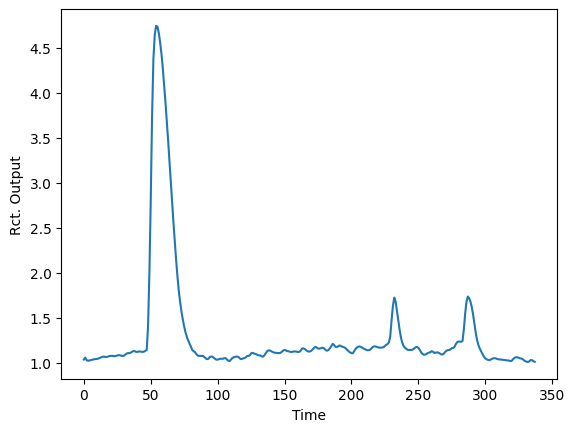

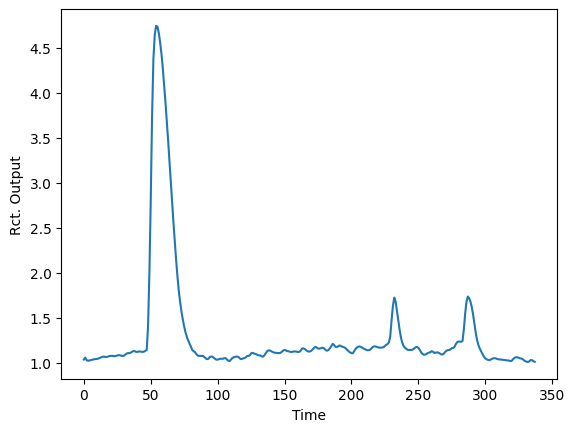

In [20]:
plot_time_series(0)

In [21]:
n_timesteps = [2, 5, 7, 10]
split_ratio = 0.8
n_batch = [4, 8]
device = '/device:GPu:0'

In [22]:
class Predictor:
  def __init__(self, device='/device:CPU:0'):
    self.models = []
    self.histories = []
    self.save_loc = ""
    self.cnt = 0
    self.datasets = []
    self.device = device
    self.scaler = MinMaxScaler()

  def feed(self, time_series):
    self.data = time_series.to_numpy().reshape(-1, 1)
    self.scaler.fit(self.data)
    self.data = self.scaler.transform(self.data)

  def make_model(self, n_features):
    self.model = None
    self.model = Sequential([
        Dense(n_features, activation='relu', input_shape=(n_features,)),
        Dense(64, activation='selu', kernel_regularizer=L2(1e-4)),
        Dense(128, activation= 'selu', kernel_regularizer=L2(1e-5)),
        Dense(128, activation='sigmoid', kernel_regularizer=L2(1e-4)),
        Dense(32),
        Dense(1)
    ])
    self.save_loc = f"model_{self.cnt}.h5"
    self.cnt += 1

  def split(self, n_timesteps, split_ratio):
    X = []
    Y = []
    for i in range(len(self.data)-n_timesteps):
      X.append(self.data[i:(i+n_timesteps)].reshape(-1,))
      Y.append(self.data[i+n_timesteps])
    self.X = np.array(X)
    self.Y = np.array(Y)
    self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.X, self.Y, test_size=1-split_ratio)
    self.datasets.append((self.x_train, self.y_train, self.x_test, self.y_test))

  def compile(self, n_features):
    self.make_model(n_features)
    print(self.model.summary())
    self.model.compile(
        optimizer= 'adam',
        loss = 'mse',
        metrics = [RootMeanSquaredError()]
    )

  def fire(self, n_timesteps, split_ratio, n_batch):
    self.split(n_timesteps, split_ratio)
    self.compile(n_timesteps)
    with tf.device(self.device):
      history = self.model.fit(self.x_train, self.y_train, epochs=100, batch_size=n_batch)
    self.histories.append(history.history)
    self.models.append(self.model)
    plt.plot(history.history['loss'])
    plt.plot(history.history['root_mean_squared_error'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Loss', 'RMSE Loss'])
    plt.show()

    self.model.save_weights(self.save_loc)
    print("Model weights saved to: ", self.save_loc)

    self.evaluate(self.cnt-1)
    return self.cnt

  def evaluate(self, key):
    mdl = self.models[key]
    mdl.load_weights(f'model_{key}.h5')
    print("Model weights loaded successfully!")
    hst = self.histories[key]
    x_train, y_train, x_test, y_test = self.datasets[key]
    results = mdl.evaluate(x_test, y_test)
    print("Evaluation metrics: ", results)
    predictions = mdl.predict(x_test)
    plt.plot(y_test, label='Actual', color='r')
    plt.plot(predictions, label='Predicted', color='g')
    plt.xlabel('Time')
    plt.ylabel('Rct. Output')
    plt.legend()
    plt.show()

  def predict(self, key):
    mdl = self.models[key-1]
    mdl.load_weights(f'model_{key-1}.h5')
    print("Model weights loaded successfully!")
    # hst = self.histories[key-1]
    split_ratio = len(self.datasets[key-1][1]) / (len(self.Y))
    x_train, y_train, x_test, y_test = self.X[:int(split_ratio*len(self.X))], self.Y[:int(split_ratio*len(self.Y))], self.X[int(split_ratio*len(self.X)):], self.Y[int(split_ratio*len(self.Y)):]
    test_predictions = self.model.predict(x_test)
    train_predictions = self.model.predict(x_train)

    return ((test_predictions, train_predictions), (x_train, y_train, x_test, y_test))

  def load_weights(self, key):
    mdl = self.models[key-1]
    mdl.load_weights(f'model_{key-1}.h5')
    print("Model weights loaded successfully!")
    hst = self.histories[key-1]
    self.model = mdl

    return (hst, mdl)

  def load_weights(self, loc, n_features):
    self.model = self.make_model(n_features)
    self.compile(n_features)
    self.model.load_weights(loc)
    print("Model weights loaded successfully!")

    return self.model

  def get_output(self):
    return self.models, self.histories

In [23]:
machine = Predictor(device=device)
machine.feed(df[3])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 20        
                                                                 
 dense_1 (Dense)             (None, 64)                320       
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 32)                4128      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29333 (114.58 KB)
Trainable params: 29333 

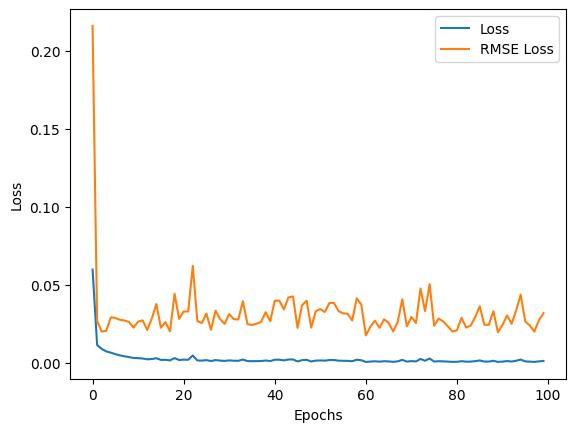

Model weights saved to:  model_0.h5
Model weights loaded successfully!
3/3 [==============================] - 0s 6ms/step - loss: 0.0014 - root_mean_squared_error: 0.0327
Evaluation metrics:  [0.0013883337378501892, 0.0326993390917778]
3/3 [==============================] - 0s 6ms/step


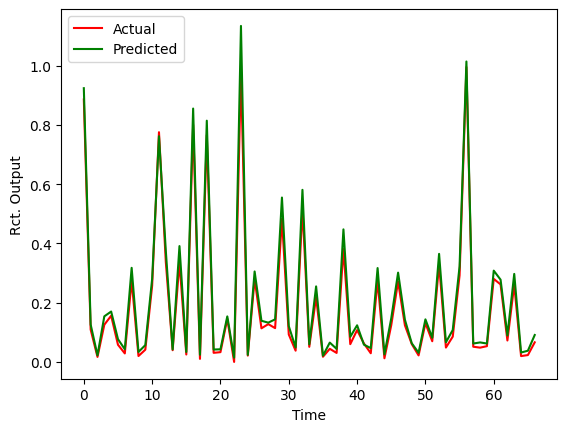

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_54 (Dense)            (None, 4)                 20        
                                                                 
 dense_55 (Dense)            (None, 64)                320       
                                                                 
 dense_56 (Dense)            (None, 128)               8320      
                                                                 
 dense_57 (Dense)            (None, 128)               16512     
                                                                 
 dense_58 (Dense)            (None, 32)                4128      
                                                                 
 dense_59 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29333 (114.58 KB)
Trainable params: 2933

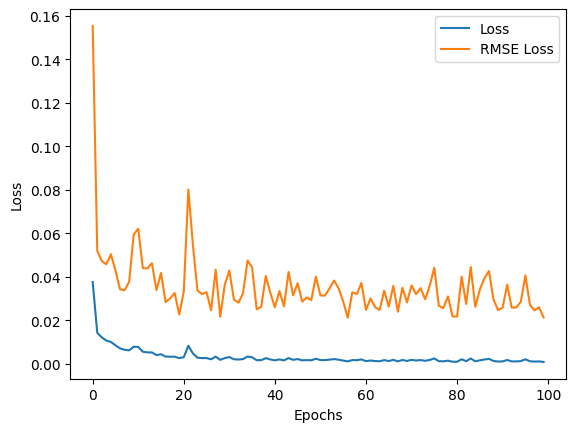

Model weights saved to:  model_0.h5
Model weights loaded successfully!
3/3 [==============================] - 0s 6ms/step - loss: 0.0015 - root_mean_squared_error: 0.0341
Evaluation metrics:  [0.001524848397821188, 0.03405247628688812]
3/3 [==============================] - 0s 4ms/step


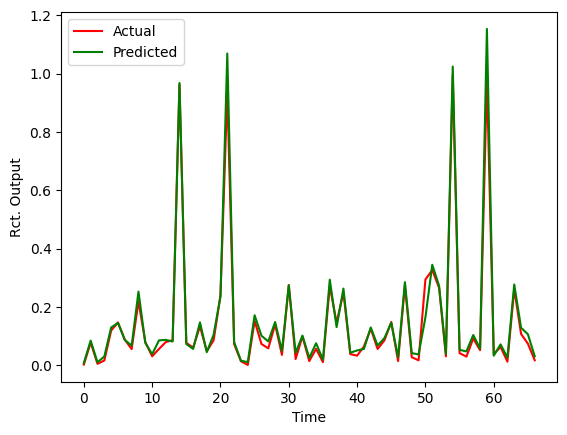

In [24]:
key = machine.fire(4, 0.8, 4)

In [25]:
predictions = machine.predict(key)

Model weights loaded successfully!
9/9 [==============================] - 0s 3ms/step
Model weights loaded successfully!
9/9 [==============================] - 0s 3ms/step


In [26]:
test_p, train_p = predictions[0]

In [27]:
test_o, train_o = predictions[1][3], predictions[1][1]

In [28]:
train = np.concatenate((train_o, test_o), axis = 0)
test = np.concatenate((train_p, test_p), axis = 0)

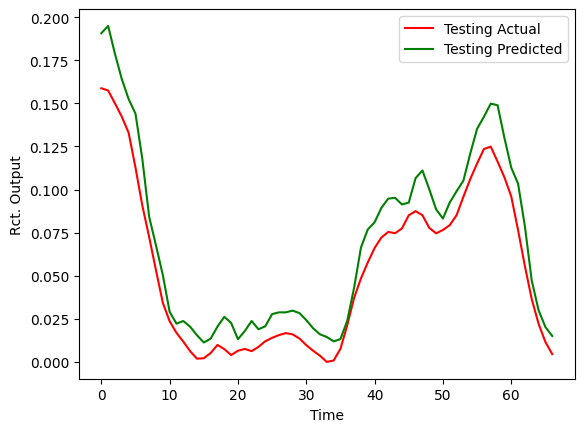

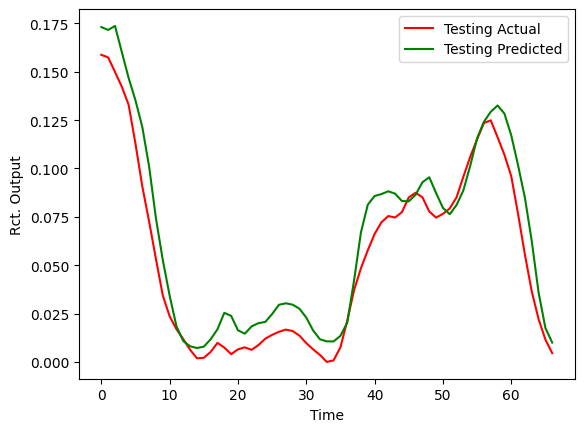

In [29]:
plt.plot(test_o, color='r')
plt.plot(test_p, color='g')
plt.xlabel('Time')
plt.ylabel('Rct. Output')
plt.legend(['Testing Actual', 'Testing Predicted'])
plt.show()

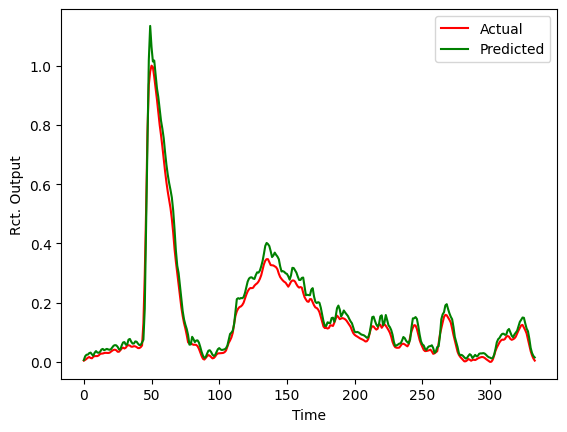

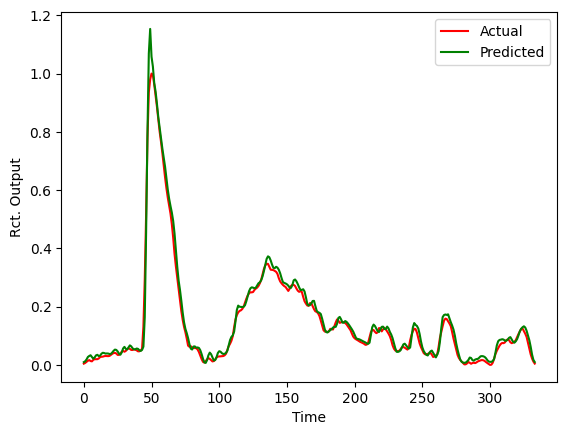

In [30]:
plt.plot(train, color='r')
plt.plot(test, color='g')
plt.xlabel('Time')
plt.ylabel('Rct. Output')
plt.legend(['Actual', 'Predicted'])
plt.show()